In [6]:
from nba_api.stats.endpoints import commonplayerinfo, playerdashboardbyyearoveryear, commonteamroster
from nba_api.stats.static import players, teams
import time
import pandas as pd
import numpy as np

#### How much can we expect players to improve in shooting?

Recently I've been wondering if we overrate how much young players can improve, so I took a look at historic trends of shooting percentages across young players careers.

In [2]:
def get_roster_dfs():
    """This method returns a dataframe containing the roster for each team in the league """
    rosters = []
    for team in teams.get_teams():
        time.sleep(1)
        team_roster = commonteamroster.CommonTeamRoster(team_id=team['id'])
        roster = team_roster.get_data_frames()[0]
        rosters.append(roster)
    return rosters

In [3]:
rosters = get_roster_dfs() # Here I obtain a list of players on each team (there may have been a simpler way to do this with another endpoint)

In [4]:
rosters[0] # Here's an example of what the roster dataframe contains

,TeamID,SEASON,LeagueID,PLAYER,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID
0,1610612737,2018,00,Justin Anderson,1,G-F,6-6,230,"NOV 19, 1993",24,3,Virginia,1626147
1,1610612737,2018,00,Tyler Dorsey,2,G,6-5,183,"FEB 18, 1996",22,1,Oregon,1628416
2,1610612737,2018,00,Kevin Huerter,3,G,6-7,190,"AUG 27, 1998",20,R,Maryland,1628989
3,1610612737,2018,00,Daniel Hamilton,5,G-F,6-7,195,"AUG 08, 1995",23,1,Connecticut,1627772
4,1610612737,2018,00,Omari Spellman,6,F,6-9,245,"JUL 21, 1997",21,R,Villanova,1629016
5,1610612737,2018,00,Jeremy Lin,7,G,6-3,200,"AUG 23, 1988",30,8,Harvard,202391
6,1610612737,2018,00,Jaylen Adams,10,G,6-2,190,"MAY 04, 1996",22,R,St. Bonaventure,1629121
7,1610612737,2018,00,Trae Young,11,G,6-2,180,"SEP 19, 1998",20,R,Oklahoma,1629027
8,1610612737,2018,00,Taurean Prince,12,F,6-8,220,"MAR 22, 1994",24,2,Baylor,1627752
9,1610612737,2018,00,Dewayne Dedmon,14,C,7-0,245,"AUG 12, 1989",29,5,Southern California,203473


In [14]:
def transform_player_stats(player_stats):
    """This method tailors the player stats to a format that we actually want"""
    player_yby = player_stats.groupby(['GROUP_VALUE'])[['FG3M', 'FG3A', 'FTM', 'FTA']].sum().reset_index()
    player_yby = player_yby.sort_values(by=['GROUP_VALUE'], ascending=True).reset_index(drop=True)
    player_yby['experience'] = player_yby.index
    
    return player_yby

def transform_player_stats_avg(player_stats):
    """This method tailors the player stats to a format that we actually want"""
    player_yby = player_stats.groupby(['GROUP_VALUE']).agg({'FG3_PCT': np.mean, 'FG3A': np.sum}).reset_index()   #[['FG3_PCT']].mean().reset_index()
    player_yby = player_yby.sort_values(by=['GROUP_VALUE'], ascending=True).reset_index(drop=True)
    player_yby['experience'] = player_yby.index
    full_df = player_yby[player_yby.FG3A > 50]

    
    return full_df

In [15]:
def get_player_stats_by_roster(roster, min_exp=4, max_exp=6):
    """This method gets all of the year by year player stats for a given roster"""
    
    player_stat_dfs = []
    for index, row in roster.iterrows():
        if row['EXP'] != 'R' and min_exp <= int(row['EXP']) <= max_exp:
            player_id = row['PLAYER_ID']
            player_name = row['PLAYER']
            time.sleep(.5)
            player_stats = playerdashboardbyyearoveryear.PlayerDashboardByYearOverYear(player_id)
            player_yby = player_stats.by_year_player_dashboard.get_data_frame()[['GROUP_SET', 'GROUP_VALUE','FG3M', 'FG3A','FG3_PCT', 'FTM', 'FTA']]
            player_yby['PLAYER_NAME'] = player_name

            player_transformed = transform_player_stats(player_yby)
            player_transformed['age'] = row['AGE']
            player_stat_dfs.append(player_transformed)
    return player_stat_dfs

def get_player_stats_by_roster_avg(roster, min_exp=4, max_exp=6):
    """This method gets all of the year by year player stats for a given roster"""
    
    player_stat_dfs = []
    for index, row in roster.iterrows():
        if row['EXP'] != 'R' and min_exp <= int(row['EXP']) <= max_exp:
            player_id = row['PLAYER_ID']
            player_name = row['PLAYER']
            time.sleep(.5)
            player_stats = playerdashboardbyyearoveryear.PlayerDashboardByYearOverYear(player_id)
            player_yby = player_stats.by_year_player_dashboard.get_data_frame()[['GROUP_SET', 'GROUP_VALUE','FG3M', 'FG3A','FG3_PCT', 'FTM', 'FTA']]
            player_yby['PLAYER_NAME'] = player_name

            player_transformed = transform_player_stats_avg(player_yby)
            player_transformed['age'] = row['AGE']
            player_stat_dfs.append(player_transformed)
    return player_stat_dfs

In [140]:
all_players = []
for r in rosters:
    stats = get_player_stats_by_roster(r)
    all_players.extend(stats)

In [143]:
full_df = pd.concat(all_players)

In [144]:
full_df = full_df[full_df.GROUP_VALUE != '2018-19']
full_df = full_df[full_df.experience < 6]

In [146]:
full_df.head(20) # Our remaining dataframe

,GROUP_VALUE,FG3M,FG3A,FTM,FTA,experience
0,2010-11,1,5,19,25,0
1,2011-12,24,75,146,183,1
2,2012-13,87,257,216,275,2
3,2013-14,82,229,218,265,3
4,2014-15,65,176,213,268,4
5,2015-16,76,226,238,292,5
0,2013-14,0,0,42,64,0
1,2014-15,0,1,34,64,1
2,2015-16,0,0,57,76,2
3,2016-17,0,0,65,93,3


In [147]:
summed_df = full_df.groupby(['experience'])[['FG3M', 'FG3A', 'FTM', 'FTA']].sum().reset_index()
summed_df['3PCT'] = summed_df['FG3M'] / summed_df['FG3A']
summed_df['FTPCT'] = summed_df['FTM'] / summed_df['FTA']
summed_df

,experience,FG3M,FG3A,FTM,FTA,3PCT,FTPCT
0,0,6148,18335,20878,28492,0.335315,0.732767
1,1,10578,29966,30208,40844,0.353000,0.739595
2,2,12978,36486,36490,47923,0.355698,0.761430
3,3,15499,42672,37699,49549,0.363212,0.760843
4,4,13003,35847,32681,42582,0.362736,0.767484
5,5,11904,32944,30179,38404,0.361340,0.785830


/Users/brent/.pyenv/versions/3.6.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


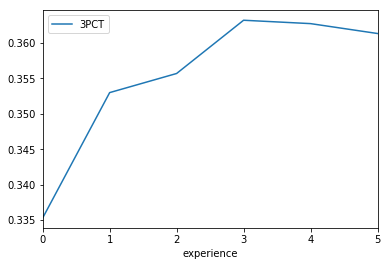

In [148]:
summed_df.plot.line(x='experience', y='3PCT')

/Users/brent/.pyenv/versions/3.6.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


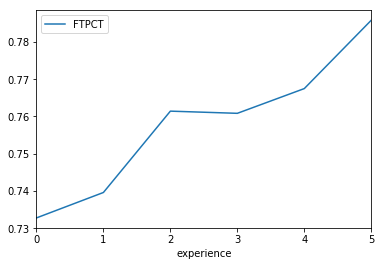

In [149]:
summed_df.plot.line(x='experience', y='FTPCT')

Takeways:

Of all current players who played at least 4 years (~ a single rooke contract), if you add up their 3ptFGM and their 3ptFGA to calculate their 3pt Pctage by their experience level in the league (1st year, 2nd year, etc..) and look at the progression across their first 5 years in the league

1. Rookies are bad at shooting 3s. There's a clear development curve between the college line and the pro one, and most likely age is a factor as well
2. Young players do exhibit a quick improvement in 3 point shooting after they've adjusted to the line, and it appears FT% just keeps increasing

#### Can veteran players experience late peaks in their careers?

In [154]:
all_players = []
for r in rosters:
    stats = get_player_stats_by_roster(r, min_exp=9, max_exp=20)
    all_players.extend(stats)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [157]:
full_df = pd.concat(all_players)
full_df = full_df[full_df.GROUP_VALUE != '2018-19']

summed_df = full_df.groupby(['experience'])[['FG3M', 'FG3A', 'FTM', 'FTA']].sum().reset_index()
summed_df['3PCT'] = summed_df['FG3M'] / summed_df['FG3A']
summed_df['FTPCT'] = summed_df['FTM'] / summed_df['FTA']
summed_df

,experience,FG3M,FG3A,FTM,FTA,3PCT,FTPCT
0,0,272,820,1169,1530,0.331707,0.764052
1,1,567,1469,1503,1908,0.385977,0.787736
2,2,729,1814,1710,2115,0.401874,0.808511
3,3,673,1723,1492,1877,0.390598,0.794885
4,4,799,2091,1178,1468,0.382114,0.802452
5,5,864,2323,1738,2187,0.371933,0.794696
6,6,832,2173,1718,2164,0.382881,0.793900
7,7,869,2352,1400,1772,0.369473,0.790068
8,8,1012,2726,1564,1950,0.371240,0.802051
9,9,1055,2633,1197,1486,0.400684,0.805518


/Users/brent/.pyenv/versions/3.6.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


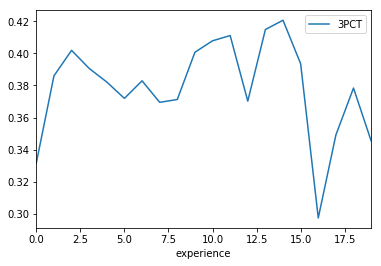

In [158]:
summed_df.plot.line(x='experience', y='3PCT')

/Users/brent/.pyenv/versions/3.6.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


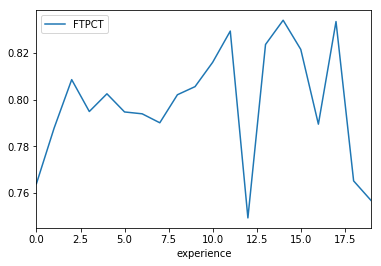

In [159]:
summed_df.plot.line(x='experience', y='FTPCT')

In [155]:
all_players[0]

,GROUP_VALUE,FG3M,FG3A,FTM,FTA,experience
0,1998-99,19,66,204,268,0
1,1999-00,95,236,436,551,1
2,2000-01,162,397,384,502,2
3,2001-02,121,313,245,307,3
4,2002-03,45,131,129,160,4
5,2003-04,93,243,336,417,5
6,2004-05,254,626,734,920,6
7,2005-06,125,367,480,601,7
8,2006-07,156,437,462,576,8
9,2007-08,98,273,350,429,9


In [163]:
ps = playerdashboardbyyearoveryear.PlayerDashboardByYearOverYear(1713)
ps2 = ps.by_year_player_dashboard.get_data_frame()
ps2
# 
# player_yby = player_stats.by_year_player_dashboard.get_data_frame()[['GROUP_SET', 'GROUP_VALUE','FG3M', 'FG3A','FG3_PCT', 'FTM', 'FTA']]


,GROUP_SET,GROUP_VALUE,TEAM_ID,TEAM_ABBREVIATION,MAX_GAME_DATE,GP,W,L,W_PCT,MIN,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS
0,By Year,2018-19,1610612737,ATL,2018-11-11T00:00:00,13,3,10,0.231,244.901667,...,1,1,16,23,18,23,17,5,264,2018-19
1,By Year,2017-18,1610612758,SAC,2018-04-11T00:00:00,58,20,38,0.345,1025.990000,...,2,4,14,22,20,20,17,5,264,2017-18
2,By Year,2016-17,1610612763,MEM,2017-04-12T00:00:00,73,36,37,0.493,1799.560000,...,7,11,9,17,8,15,17,5,264,2016-17
3,By Year,2015-16,1610612763,MEM,2016-04-13T00:00:00,60,33,27,0.550,1005.353333,...,5,5,11,18,18,19,17,5,264,2015-16
4,By Year,2014-15,1610612763,MEM,2015-04-15T00:00:00,66,45,21,0.682,1091.243333,...,6,6,12,19,14,18,17,5,264,2014-15
5,By Year,2013-14,1610612742,DAL,2014-04-16T00:00:00,81,49,32,0.605,1972.956667,...,10,16,7,12,7,12,13,5,264,2013-14
6,By Year,2012-13,1610612742,DAL,2013-04-17T00:00:00,81,41,40,0.506,2092.750000,...,12,18,6,11,4,11,13,5,264,2012-13
7,By Year,2011-12,1610612742,DAL,2012-04-26T00:00:00,61,33,28,0.541,1542.023333,...,9,9,8,16,5,16,13,5,264,2011-12
8,By Year,2010-11,-1,TOT,2011-04-13T00:00:00,73,38,35,0.521,2051.561667,...,1,1,1,2,1,2,2,1,264,2010-11
9,By Year,2010-11,1610612756,PHX,2011-04-13T00:00:00,51,25,26,0.490,1387.156667,...,11,8,10,15,16,17,11,5,264,2010-11


#### What if we consider players age instead of how long they've been in the league?

In [11]:
all_players = []
for r in rosters:
    stats = get_player_stats_by_roster(r, min_exp=4, max_exp=20)
    all_players.extend(stats)

In [13]:
len(all_players)

229

In [19]:
all_players[8]

,GROUP_VALUE,FG3M,FG3A,FTM,FTA,experience,age
0,2010-11,35,74,69,97,0,28
1,2011-12,55,159,193,232,1,28
2,2012-13,102,246,243,294,2,28
3,2013-14,85,280,311,381,3,28
4,2014-15,120,330,375,462,4,28
5,2015-16,143,410,393,477,5,28
6,2016-17,149,374,362,429,6,28
7,2017-18,0,1,0,0,7,28
8,2018-19,15,47,16,21,8,28


In [36]:
full_df = pd.concat(all_players)

In [37]:
players_with_age = full_df

In [40]:
# players_with_age['age'] = players_with_age['GROUP_VALUE'].str.slice(0,4)
players_with_age['yr'] = players_with_age.GROUP_VALUE.str[:4]
players_with_age['yr'] = players_with_age['yr'].astype(int)
players_with_age['adj_age'] = players_with_age['age'] - (2018 - players_with_age['yr'])

In [43]:
players_with_age['yr'] = players_with_age['yr'].astype(int)
players_with_age['adj_age'] = players_with_age['age'] - (2018 - players_with_age['yr'])

In [44]:
players_with_age['adj_age'] = players_with_age['age'] - (2018 - players_with_age['yr'])

In [46]:
players_with_age.to_csv('players_with_age.csv')

In [47]:
players_with_age

,GROUP_VALUE,FG3M,FG3A,FTM,FTA,experience,age,yr,adj_age
0,2010-11,1,5,19,25,0,30,2010,22
1,2011-12,24,75,146,183,1,30,2011,23
2,2012-13,87,257,216,275,2,30,2012,24
3,2013-14,82,229,218,265,3,30,2013,25
4,2014-15,65,176,213,268,4,30,2014,26
5,2015-16,76,226,238,292,5,30,2015,27
6,2016-17,58,156,115,141,6,30,2016,28
7,2017-18,1,2,7,7,7,30,2017,29
8,2018-19,9,27,40,45,8,30,2018,30
0,2013-14,0,0,42,64,0,29,2013,24


In [48]:
summed_df2 = players_with_age.groupby(['adj_age'])[['FG3M', 'FG3A', 'FTM', 'FTA']].sum().reset_index()
summed_df2['3PCT'] = summed_df2['FG3M'] / summed_df2['FG3A']
summed_df2['FTPCT'] = summed_df2['FTM'] / summed_df2['FTA']
summed_df2.to

,adj_age,FG3M,FG3A,FTM,FTA,3PCT,FTPCT
0,18,111,360,784,1103,0.308333,0.710789
1,19,1258,3761,5806,7971,0.334486,0.728390
2,20,3133,9376,13838,19127,0.334151,0.723480
3,21,5743,16798,22195,29931,0.341886,0.741539
4,22,8877,25361,28997,38931,0.350026,0.744831
5,23,11510,32553,31452,41540,0.353577,0.757150
6,24,12831,35731,32825,42889,0.359100,0.765348
7,25,13445,36744,31081,39908,0.365910,0.778816
8,26,13006,35829,29718,38197,0.363002,0.778019
9,27,12624,34483,28381,35847,0.366093,0.791726


/Users/brent/.pyenv/versions/3.6.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


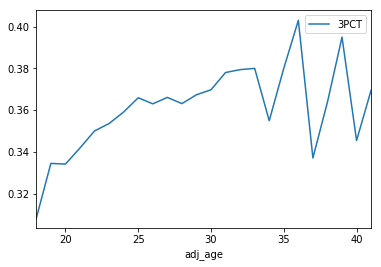

In [51]:
summed_df2.plot.line(x='adj_age', y='3PCT')

/Users/brent/.pyenv/versions/3.6.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


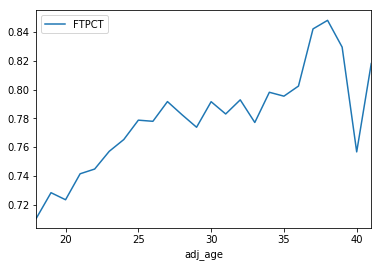

In [52]:
summed_df2.plot.line(x='adj_age', y='FTPCT')

#### Observations
We see that there is a steady progression in shooting until around age 25 and then it begins to plateaus. 25 serves as a pretty clear pivot point here, so much so that maybe we simply shouldn't judge a player's shooting until their age 25 season.

Next: if you hit maybe, 38% shooting at a given age, does that mean you're good to go?
Should also look at rolling averages of shooting splits


If a player has > something in first seasons, can we predict a high ppg?
How free throw attempt rate would be better for this

In [54]:
from sklearn import linear_model


ModuleNotFoundError: No module named 'sklearn'

In [16]:
all_players = []
for r in rosters:
    stats = get_player_stats_by_roster_avg(r, min_exp=4, max_exp=20)
    all_players.extend(stats)

In [21]:
all_players[0]


,GROUP_VALUE,FG3_PCT,FG3A,experience,age
1,2011-12,0.320,75,1,30
2,2012-13,0.339,257,2,30
3,2013-14,0.358,229,3,30
4,2014-15,0.369,176,4,30
5,2015-16,0.336,226,5,30
6,2016-17,0.372,156,6,30


In [26]:
full_df = pd.concat(all_players)
players_with_age = full_df
players_with_age['yr'] = players_with_age.GROUP_VALUE.str[:4]
players_with_age['yr'] = players_with_age['yr'].astype(int)
players_with_age['adj_age'] = players_with_age['age'] - (2018 - players_with_age['yr'])
players_with_age.head(8)
# summed_df3 = players_with_age.groupby(['adj_age']).agg({'FG3_PCT': np.mean, 'FG3A': np.sum}).reset_index() #[['FG3_PCT']].mean().reset_index()
# summed_df3['3PCT'] = summed_df2['FG3M'] / summed_df2['FG3A']
# summed_df3['FTPCT'] = summed_df2['FTM'] / summed_df2['FTA']
# summed_df3

,GROUP_VALUE,FG3_PCT,FG3A,experience,age,yr,adj_age
1,2011-12,0.320,75,1,30,2011,23
2,2012-13,0.339,257,2,30,2012,24
3,2013-14,0.358,229,3,30,2013,25
4,2014-15,0.369,176,4,30,2014,26
5,2015-16,0.336,226,5,30,2015,27
6,2016-17,0.372,156,6,30,2016,28
4,2017-18,0.355,141,4,29,2017,28
0,1998-99,0.288,66,0,41,1998,21


In [27]:
summed_df3 = players_with_age.groupby(['adj_age']).agg({'FG3_PCT': np.mean, 'FG3A': np.mean}).reset_index() #[['FG3_PCT']].mean().reset_index()
summed_df3

,adj_age,FG3_PCT,FG3A
0,18,0.318500,167.500000
1,19,0.338444,186.944444
2,20,0.335047,168.380000
3,21,0.328483,201.112500
4,22,0.346331,217.567568
5,23,0.346431,231.145985
6,24,0.350598,251.640288
7,25,0.360721,268.451128
8,26,0.350475,257.948529
9,27,0.361259,297.482143


/Users/brent/.pyenv/versions/3.6.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


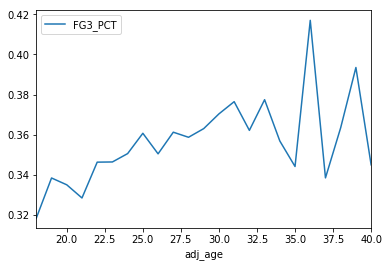

In [28]:
summed_df3.plot.line(x='adj_age', y='FG3_PCT')

In [29]:
summed_df4 = players_with_age.groupby(['experience']).agg({'FG3_PCT': np.mean, 'FG3A': np.mean}).reset_index() #[['FG3_PCT']].mean().reset_index()
summed_df4

,experience,FG3_PCT,FG3A
0,0,0.332641,161.233010
1,1,0.343295,211.441176
2,2,0.349804,230.451613
3,3,0.355501,265.828025
4,4,0.354669,245.469388
5,5,0.357322,268.495935
6,6,0.356152,282.180952
7,7,0.360275,277.340659
8,8,0.358793,283.306667
9,9,0.373040,268.086207


/Users/brent/.pyenv/versions/3.6.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


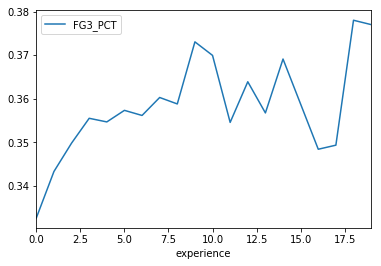

In [30]:
summed_df4.plot.line(x='experience', y='FG3_PCT')

In [31]:
all_players[0]

,GROUP_VALUE,FG3_PCT,FG3A,experience,age
1,2011-12,0.320,75,1,30
2,2012-13,0.339,257,2,30
3,2013-14,0.358,229,3,30
4,2014-15,0.369,176,4,30
5,2015-16,0.336,226,5,30
6,2016-17,0.372,156,6,30


In [130]:
# bad_shooters = [player for player in all_players if len(player.query('experience==0')['FG3_PCT']) > 0 and float(player.query('experience==0')['FG3_PCT'].iloc[0]) < 0.31]
bad_shooters = [player for player in all_players if len(player.query('experience==0')['FG3_PCT']) > 0 and 0.33 < float(max(player.query('experience==0')['FG3_PCT'])) < 0.37]


In [131]:
len(bad_shooters)

28

In [132]:
full_bad_shooters = pd.concat(bad_shooters)
summed_df5 = full_bad_shooters.groupby(['experience']).agg({'FG3_PCT': np.mean, 'FG3A': np.mean}).reset_index() #[['FG3_PCT']].mean().reset_index()
summed_df5

,experience,FG3_PCT,FG3A
0,0,0.354000,186.821429
1,1,0.358680,250.640000
2,2,0.353210,273.222222
3,3,0.356298,291.142857
4,4,0.369933,261.960000
5,5,0.337824,258.058824
6,6,0.347489,241.000000
7,7,0.352212,285.909091
8,8,0.347104,429.375000
9,9,0.352714,291.000000


/Users/brent/.pyenv/versions/3.6.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


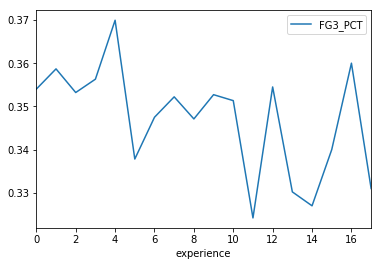

In [133]:
summed_df5.plot.line(x='experience', y='FG3_PCT')

In [52]:
# t = all_players[0].query('experience<=3')['FG3_PCT']
# type(max(t))

In [135]:
bad_shooters[22]

,GROUP_VALUE,FG3_PCT,FG3A,experience,age
0,2011-12,0.340,94,0,28
1,2012-13,0.293,92,1,28
2,2013-14,0.331,133,2,28
3,2014-15,0.255,51,3,28
4,2015-16,0.326,190,4,28
5,2016-17,0.306,196,5,28
6,2017-18,0.352,273,6,28
7,2018-19,0.273,55,7,28


In [ ]:
bad_shooters[22]